## Preparation

In [1]:
# =======
# import modules   
#from dypy.netcdf import read_var
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from lagranto import Tra
import numpy as np
#import scipy as sp
import matplotlib.pyplot as plt
import xarray as xr
from datetime import date, datetime, timedelta

In [2]:
# --------------------------------------------------------------------------------------------------
# Functions for plotting trajectories
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    return segments


# Interface to LineCollection:
def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha, transform=ccrs.PlateCarree())

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

In [3]:
# colormap for trajectories
from matplotlib.colors import from_levels_and_colors
colors = [#more detailed 18 colors
    [130,0,0], #rot
    [160,0,0], 
    [190,0,0], 
    [220,30,0],
    [250,60,0],
    [250,90,0],
    [250,120,0],   #orange
    [250,170,30],   #yellow
    [250,200,90],   
    [250,220,150], #MITTE
    [0,220,250],   #cyan
    [0,90,250],  #blue
    [0,60,250],
    [0,60,220],
    [0,30,190], 
    [0,30,160], 
    [0,30,130], 
]  
levels =  [200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950] # 17 levels  
# convert RGB values to range between 0 - 1
colors = np.array(colors)/255
# creat colormap
cmap, norm = from_levels_and_colors(levels, colors, extend='both')


## Define Path, Date and read data

In [4]:
# define path
# tradir = "/net/scratch/schoelleh96/LAGRANTO/Henry/traj/2010/"
tradir = "/net/scratch/schoelleh96/WP2/WP2.1/LAGRANTO/wp21/traj/1981/"

#define date 
date = datetime(1981,1,9,0) 

# define filename
blockname = str(date.year) + ".nc"
traname = date.strftime('traj_%Y%m%d_%H')

In [5]:
# read files

#ds_block = xr.open_dataset(blockdir + blockname)

trajs = Tra()
trajs.load_ascii(tradir + traname, gz=False)

In [6]:
# print trajs
print(trajs)
# print(trajs.ntr())
print(trajs['lon'].shape)
trajs.set_array(trajs.get_array().transpose())
print(trajs)
print(trajs['lon'].shape)


             169 trajectories with 7632 time steps. 
             Available fields: time/lon/lat/p/T/Q/TH/PS/RH
             total duration: 0.0 minutes
(169, 7632)
             7632 trajectories with 169 time steps. 
             Available fields: time/lon/lat/p/T/Q/TH/PS/RH
             total duration: -10080.0 minutes
(7632, 169)


## Plot trajectories

Text(0.5, 1.0, '7 days backward')

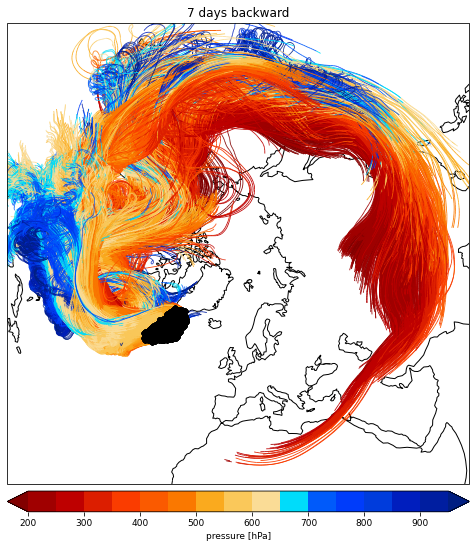

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.coastlines()
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
# =======
# plot trajectories
n_tra = len(trajs['lon'])
# loop through trajectories
for i in range(0,n_tra,1): # plot only every nth trajectory
    
    # color the line 
    
    #h4 = colorline(trajs['lon'][i], trajs['lat'][i], trajs['p'][i], norm=norm , linewidth=0.8, cmap=cmap)
    # for blocks close to dateline: trajs['lon'][i][0:15]%360
    
    # cosmetic: lines that cross the 180° longitude create ugly artefacts
    
    segment = np.vstack((trajs['lon'][i], trajs['lat'][i]))  
    lon0 = 180 #center of map
    bleft = lon0-181.                                                                            
    bright = lon0+181.
    segment[0,segment[0]> bright] -= 360.                                                                 
    segment[0,segment[0]< bleft]  += 360.
    threshold = 180.  # CHANGE HERE                                                                                    
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]                                                                                         
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:                                                                                  
        x,y = seg[0],seg[1]                                                                          
        #ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())  
        h4 = colorline(x, y, trajs['p'][i],norm=norm , linewidth=0.8, cmap=cmap)
    
    # showing location of air parcel along trajectoriy, for example 0 days before in block
    ax.scatter(trajs['lon'][i,0], trajs['lat'][i,0], color='black', s=7, zorder=5, transform=ccrs.PlateCarree())
    #ax.scatter(trajs1['lon'][i,cross[i]], trajs1['lat'][i,cross[i]], color='magenta', s=5, zorder=5, transform=ccrs.PlateCarree())

# add colorbar
# =======
#add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cbax = divider.append_axes('bottom', size="4.5%", pad=0.1, axes_class=plt.Axes)
cbar = plt.colorbar(h4, cax=cbax, orientation='horizontal')
cbar.set_label('pressure [hPa]',size=9)
cbar.ax.tick_params(labelsize=9)

ax.set_title("7 days backward")
# dth3=dth_minmax(trajs,12)
# total = len(dth3)
# fraction_lh = sum(x >= 0 for x in dth3)*100/total
# print(fraction_lh)

## Calculate change in theta along all trajectories (of all blocks)

In [8]:
# get file names and date
from os import walk  
for (dirpath, dirnames, filenames) in walk(tradir):
    print(filenames)
    break    
filenames = sorted(filenames)

['traj_19810108_12', 'traj_19810111_18', 'traj_19810113_00', 'traj_19810112_06', 'traj_19810110_18', 'traj_19810109_00', 'traj_19810113_18', 'traj_19810112_12', 'traj_19810111_00', 'traj_19810114_00', 'traj_19810113_06', 'traj_19810111_06', 'traj_19810109_06', 'traj_19810110_06', 'traj_19810112_18', 'traj_19810111_12', 'traj_19810114_12', 'traj_19810115_00', 'traj_19810114_18', 'traj_19810110_00', 'traj_19810113_12', 'traj_19810110_12', 'traj_19810108_18', 'traj_19810109_12', 'traj_19810112_00', 'traj_19810114_06', 'traj_19810109_18']


In [9]:
def dth_minmax(data, hmin): 
    'max/min change of Theta until time where smallest/biggest Theta' # TIME DURATION [0:168] = 7Days. [0:72] = 3Days
    # this takes always the biggest difference: dth = np.max(data['TH'][:,:hmin],axis=1) - np.min(data['TH'][:,:hmin], axis=1) 
    ind_r = np.argmin(data['TH'][:,:hmin], axis=1) # timestep at which minimum th occurs for every traj
    ind_l = np.argmax(data['TH'][:,:hmin], axis=1) # timestep at which maximum th occurs for every traj    
    dth = np.empty(0)
    for jj in range(0,np.size(ind_r)): # for everey traj
        y = np.max(data['TH'][jj,:(ind_r[jj]+1)]) - data['TH'][jj,ind_r[jj]] # difference between max(th, up till point of min th + 1) and min(th); always >=0, maximum latent heating
        x = np.min(data['TH'][jj,:(ind_l[jj]+1)]) - data['TH'][jj,ind_l[jj]] # difference between min(th, up till point of min th + 1) and max(th); always <=0, maximum latent cooling        
        if (np.absolute(y) >= np.absolute(x)) or (np.absolute(y) >= 2): # if either lh is >= 2 or lh is >= lc
            dth = np.r_[dth,y]
        else:
            dth = np.r_[dth,x]
    return dth

In [28]:
# =======      
# initialize list
dth7 = []
dth3 = []

# =======      
# loop over files
for ii in range(0,len(filenames)):
    # print(ii, 'from', len(filenames))
    # read data
    data = Tra()
    data.load_ascii(tradir + filenames[ii], gz=False)
    data.set_array(data.get_array().transpose())
    #get data
    print(filenames[ii])
    dth7.extend(dth_minmax(data,168))
    dth3_curr = dth_minmax(data,72)
    dth3.extend(dth3_curr)
    total = len(dth3_curr)
    fraction_lh = sum(x >= 2 for x in dth3_curr)*100/total
    print(fraction_lh)
# list to array
dth7 = np.asarray(dth7)
dth3 = np.asarray(dth3)

traj_19810108_12
84.61538461538461
traj_19810108_18
85.26785714285714
traj_19810109_00
80.35714285714286
traj_19810109_06
72.91666666666667
traj_19810109_12
58.41836734693877
traj_19810109_18
45.67307692307692
traj_19810110_00
45.6140350877193
traj_19810110_06
45.97457627118644
traj_19810110_12
36.440677966101696
traj_19810110_18
23.588709677419356
traj_19810111_00
31.71641791044776
traj_19810111_06
51.298701298701296
traj_19810111_12
69.41176470588235
traj_19810111_18
71.90860215053763
traj_19810112_00
61.224489795918366
traj_19810112_06
49.1421568627451
traj_19810112_12
40.654205607476634
traj_19810112_18
38.43457943925234
traj_19810113_00
37.5
traj_19810113_06
43.68421052631579
traj_19810113_12
49.473684210526315
traj_19810113_18
60.27777777777778
traj_19810114_00
66.8010752688172
traj_19810114_06
73.59550561797752
traj_19810114_12
70.9375
traj_19810114_18
64.69594594594595


In [11]:
# calculate fraction of diabatically heated trajectories
dth7= dth_minmax(trajs,168)
dth3 = dth_minmax(trajs,72)

total = len(dth7)
fraction_lh = sum(x >= 0 for x in dth7)*100/total
print(fraction_lh)
total = len(dth3)
fraction_lh = sum(x >= 0 for x in dth3)*100/total
print(fraction_lh)

83.17610062893081
78.812893081761


Text(0, 0.5, 'Probability density')

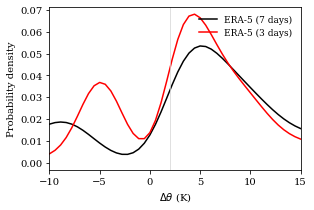

In [12]:
# plot distribution
import scipy.stats as st

# Peform the kernel density estimate
data7 = np.nan_to_num(dth7)
data3 = np.nan_to_num(dth3)

kde7 = st.gaussian_kde(dth7)
kde3 = st.gaussian_kde(dth3)
dist_space = np.linspace( -15, 40, 100 )    
f7_era = kde7(dist_space)
f3_era = kde3(dist_space)

# =======
# Plotting

plt.rc('font', family='serif')
#plt.style.use('dark_background')
f, ax = plt.subplots(1, 1, figsize=(4.5,3))

# plot Era-Interim
ax.plot(dist_space, f7_era, linewidth=1.5, color='black', linestyle='-', label = 'ERA-5 (7 days)', zorder=2)
ax.plot(dist_space, f3_era, linewidth=1.5, color='red', linestyle='-', label = 'ERA-5 (3 days)', zorder=2)

plt.axvline(2, color='lightgray',linewidth=0.7)#, linestyle='--')
#plt.figtext(0.36, 0.038, r"2", color='black', fontsize=11)

ax.set_xlim(-10, 15)
ax.set_xticks(np.arange(-10, 15+1, 5))
# ax.set_ylim(0.0, 0.06)
#ax.set_yticks(np.arange(0, 0.151, 0.03))
ax.legend(loc="upper right", prop={'size': 9},frameon=False) 
ax.set_xlabel(r"$\Delta\theta$ (K)")
ax.set_ylabel('Probability density')   

In [13]:
# Plot diabatically heated and cooled trajectories separately
print(n_tra)
print(total)

224
6025
